In [193]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


#ignore the warnings
import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing

The initial phase of machine learning invariably involves collecting data and refining it to an optimal format suitable for input into the training model. We are already given our dataset, ence forth we only need to do the processing part.

## Creating the Dataframe

We now must create a dataframe in order to access and work with the data in the csv file. We will be using Pandas as it's a powerful and user-friendly library for data manipulation and analysis in Python. 

As we can see, all data points are loaded correctly.

In [194]:
df = pd.read_csv('data/Autism Dataset for Toddlers.csv')

display(df.head())
display(df.describe())

,Case_No,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,Age_Mons,Qchat-10-Score,Sex,Ethnicity,Jaundice,Family_mem_with_ASD,Who completed the test,Class/ASD Traits
0,1,0,0,0,0,0,0,1,1,0,1,28,3,f,middle eastern,yes,no,family member,No
1,2,1,1,0,0,0,1,1,0,0,0,36,4,m,White European,yes,no,family member,Yes
2,3,1,0,0,0,0,0,1,1,0,1,36,4,m,middle eastern,yes,no,family member,Yes
3,4,1,1,1,1,1,1,1,1,1,1,24,10,m,Hispanic,no,no,family member,Yes
4,5,1,1,0,1,1,1,1,1,1,1,20,9,f,White European,no,yes,family member,Yes


,Case_No,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,Age_Mons,Qchat-10-Score
count,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000
mean,527.500000,0.563567,0.448767,0.401328,0.512334,0.524668,0.576850,0.649905,0.459203,0.489564,0.586338,27.867173,5.212524
std,304.407895,0.496178,0.497604,0.490400,0.500085,0.499628,0.494293,0.477226,0.498569,0.500128,0.492723,7.980354,2.907304
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000
25%,264.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.000000,3.000000
50%,527.500000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,30.000000,5.000000
75%,790.750000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,36.000000,8.000000
max,1054.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,36.000000,10.000000


### Check missing data

There's no missing data, so we are free to move forward

In [195]:
df.isna().any()


Case_No                   False
A1                        False
A2                        False
A3                        False
A4                        False
A5                        False
A6                        False
A7                        False
A8                        False
A9                        False
A10                       False
Age_Mons                  False
Qchat-10-Score            False
Sex                       False
Ethnicity                 False
Jaundice                  False
Family_mem_with_ASD       False
Who completed the test    False
Class/ASD Traits          False
dtype: bool

## Encoding the target variable

Before moving forward, we must note the fact that the target variable (the result that the model will try to predict) is not in a suitable format for analysis. We can easily use LabelEncoder to transform it into an Integer value, where 1 represents a positive ASD Traits result and 0 represents a negative result.

In [196]:
df.rename(columns={'Class/ASD Traits ': 'Class/ASD Traits'}, inplace=True)

encoder = LabelEncoder()

df['Class/ASD Traits'] = encoder.fit_transform(df['Class/ASD Traits'])
df.head()

,Case_No,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,Age_Mons,Qchat-10-Score,Sex,Ethnicity,Jaundice,Family_mem_with_ASD,Who completed the test,Class/ASD Traits
0,1,0,0,0,0,0,0,1,1,0,1,28,3,f,middle eastern,yes,no,family member,0
1,2,1,1,0,0,0,1,1,0,0,0,36,4,m,White European,yes,no,family member,1
2,3,1,0,0,0,0,0,1,1,0,1,36,4,m,middle eastern,yes,no,family member,1
3,4,1,1,1,1,1,1,1,1,1,1,24,10,m,Hispanic,no,no,family member,1
4,5,1,1,0,1,1,1,1,1,1,1,20,9,f,White European,no,yes,family member,1


# Data Analysis

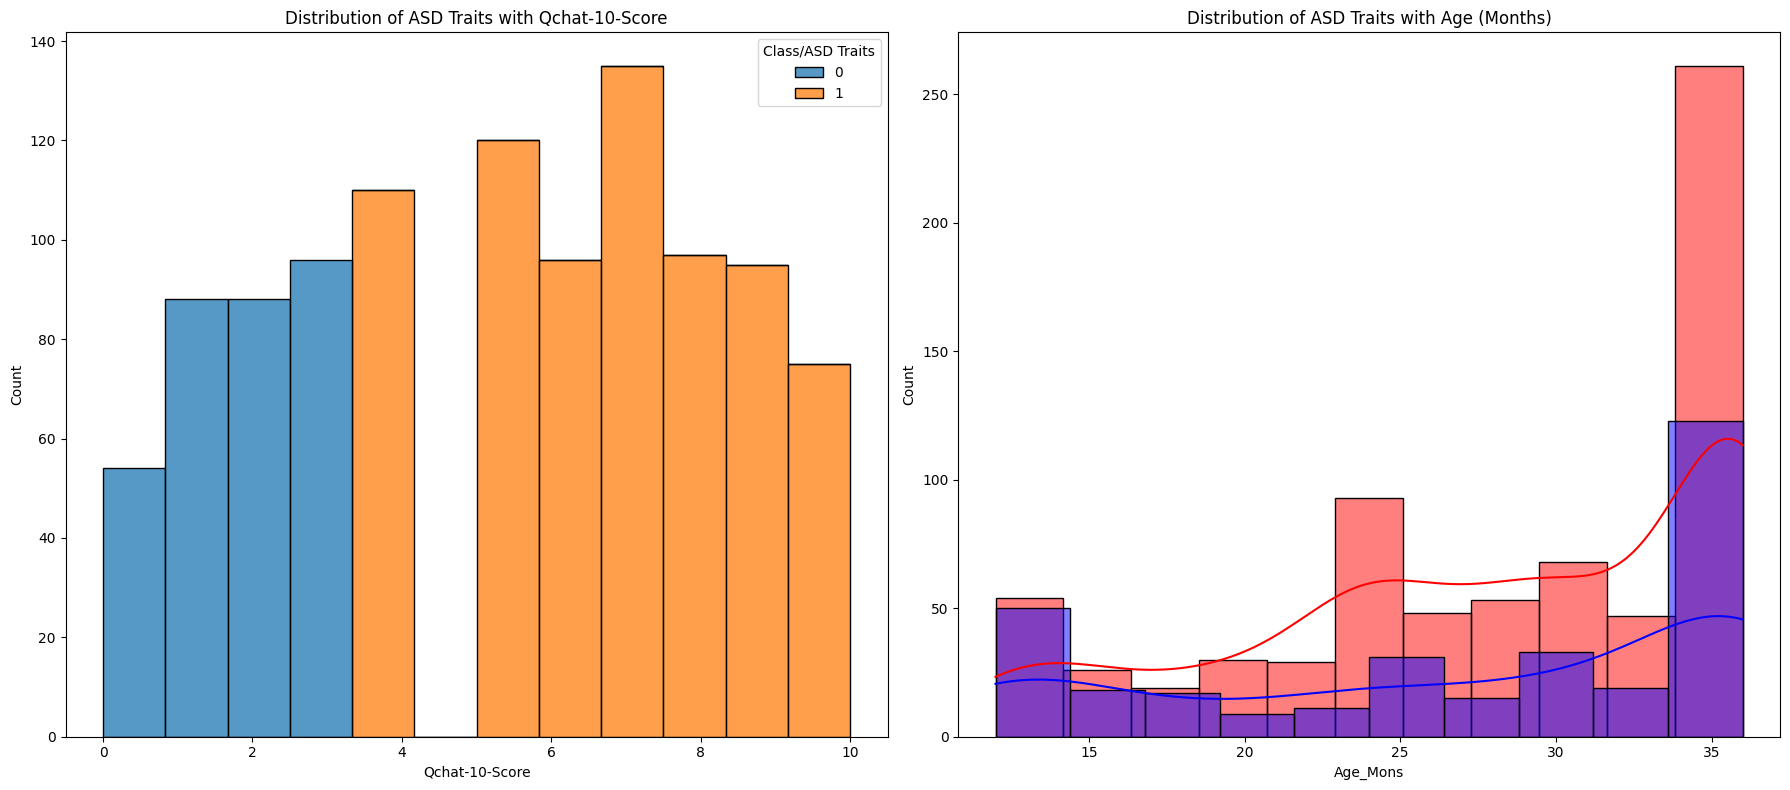

In [197]:
# Divide the DataFrame based on ASD diagnosis
df1 = df[df['Class/ASD Traits'] == 1]
df2 = df[df['Class/ASD Traits'] == 0]

# Set up the figure and subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# Plot distribution of ASD traits with Qchat-10-Score
sb.histplot(data=df, x='Qchat-10-Score', hue='Class/ASD Traits', multiple='stack', ax=axes[0])
axes[0].set_title('Distribution of ASD Traits with Qchat-10-Score')

# Plot distribution of ASD traits with Age in Months
sb.histplot(data=df1, x='Age_Mons', color='red', label='ASD Traits', kde=True, ax=axes[1])
sb.histplot(data=df2, x='Age_Mons', color='blue', label='Non ASD Traits', kde=True, ax=axes[1])
axes[1].set_title('Distribution of ASD Traits with Age (Months)')

plt.tight_layout()
plt.show()

The first graph shows the correlation between the *Qchat-10-Score* and the target variable. This shows us that those are 2 directly correlated and that having a value above 3 means that the toddler does in fact have ASD traits. Therefore, we must not use it to train the model and we will be removing it from the prepared dataframe.

The second graph shows the correlation between the *age of the child in months at the time of testing* and the target variable. A direct correlation doesn't immediately jump out, therefore we can assume this can be used to train the model, although we will still subject it to further analysis

In [198]:
#Remove Qchat-10-Score from dataframe
df.drop(['Qchat-10-Score'], axis=1, inplace=True)


### Encoding Non Numerical Features

In [199]:
# Encode categorical variables 'Jaundice' and 'Family_mem_with_ASD'
df['Jaundice'] = encoder.fit_transform(df['Jaundice'])
df['Family_mem_with_ASD'] = encoder.fit_transform(df['Family_mem_with_ASD'])


The rest of the Non Numerical Variables aren't suitable for use in the training model. These are the *Ethnicity*, *Sex*  and *Who completed the test* and we will be thus removing them from the dataframe.

We will also be removing Case_no as it provides no useful information.

In [200]:
#Remove Sex, Ethnicity, Who completed and Case_No the test from dataframe
df.drop(["Sex","Ethnicity","Who completed the test","Case_No"], axis=1, inplace=True)

### Correlation with Target Variable

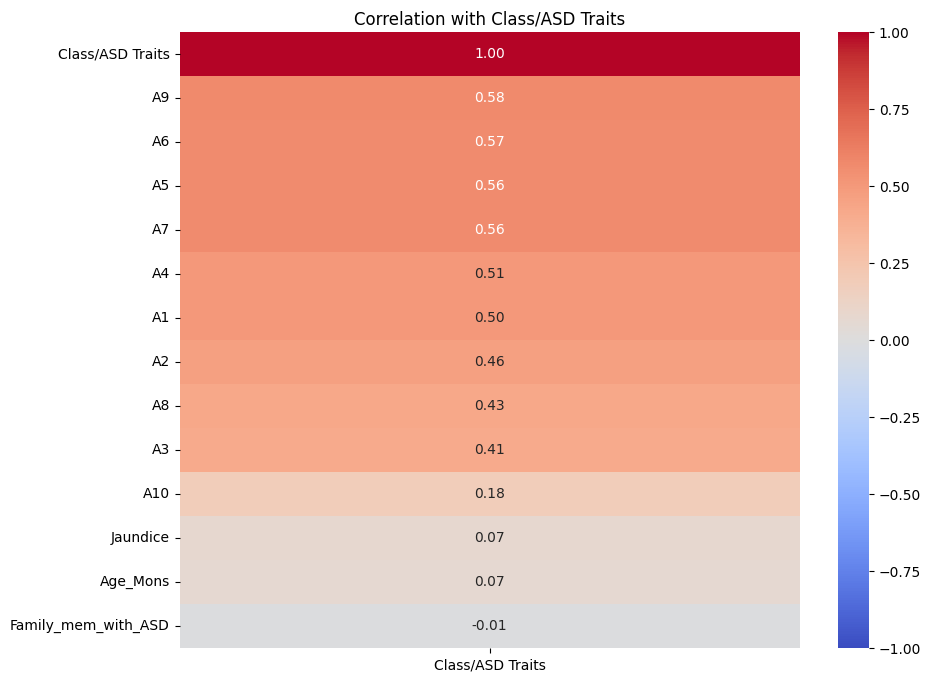

In [201]:
# Create correlation matrix
correlation = df.corr()['Class/ASD Traits'].sort_values(ascending=False)

# Plot correlation matrix heatmap
plt.figure(figsize=(10, 8))
sb.heatmap(correlation.to_frame(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation with Class/ASD Traits')
plt.show()


### Correlation Matrix

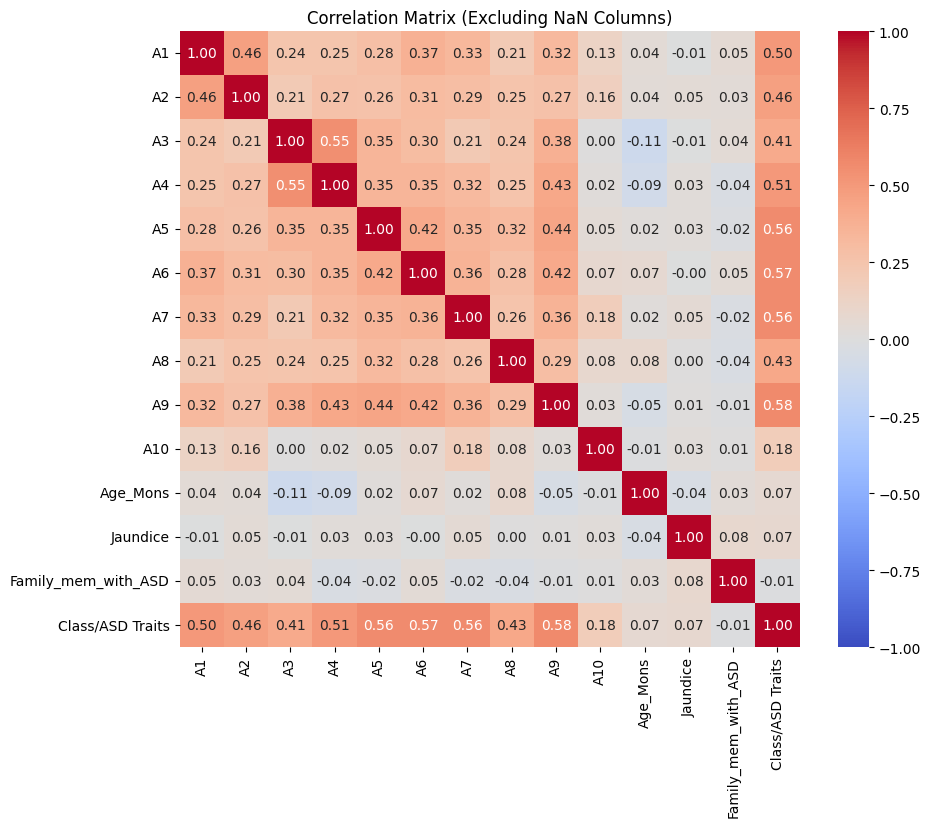

In [202]:

# Calculate correlation matrix
correlation_matrix = df.corr()


# Plot correlation matrix heatmap
plt.figure(figsize=(10, 8))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Matrix (Excluding NaN Columns)')
plt.show()

### Highly Correlated Features

Two features are highly correlated when their correlation value surpasses a certain threshold, which is normally 0.95 . When these pair exists, we remove one of the features from the dataframe as it can lead to multicollinearity issues and doesn't provide additional meaningful information for modeling. Removing one of the highly correlated features helps in reducing redundancy and improving the model's interpretability and performance.

In [203]:
# Define the correlation threshold
threshold = 0.95

# Create an empty list to store highly correlated feature pairs
highly_correlated_pairs = []

# Iterate through the correlation matrix to find highly correlated feature pairs
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            feature1 = correlation_matrix.columns[i]
            feature2 = correlation_matrix.columns[j]
            highly_correlated_pairs.append((feature1, feature2))

# Print highly correlated feature pairs
if len(highly_correlated_pairs) > 0:
    print("Highly correlated feature pairs:")
    for pair in highly_correlated_pairs:
        print(pair)
else:
    print("No highly correlated feature pairs found.")

No highly correlated feature pairs found.


As there's no highly correlated pair, we see that we were given a good dataset and we are free to 

# Preparing the dataframe for model training

In [204]:
# Separate the target from the features
target = df['Class/ASD Traits']
features = df.drop(['Class/ASD Traits'],axis=1)

### Check for Null Values

In [205]:
# Check for NaN values in the features DataFrame
nan_columns = features.columns[features.isna().any()].tolist()

# Print columns with NaN values
if nan_columns:
    print("Columns with NaN values:")
    for column in nan_columns:
        print(column)
else:
    print("No NaN values found in the DataFrame.")


No NaN values found in the DataFrame.


## Oversampling

In [206]:
#Count data for each of the results
unique_values, counts = np.unique(target, return_counts=True)

print(f"{counts[0]} negative results!")
print(f"{counts[1]} positive results!")

326 negative results!
728 positive results!


As we can see, we have almost double the ammount of positive cases compared to the negative cases. This is not advisable as this imbalance can lead to biased models that favor the majority class and perform poorly on the minority class. Oversampling techniques like SMOTE (Synthetic Minority Over-sampling Technique) generate synthetic examples for the minority class, balancing the dataset and improving the model's ability to learn from both classes effectively. This helps prevent the model from being biased toward the majority class and improves its overall performance, especially in scenarios where correctly identifying minority instances is crucial.


We chose **SMOTE** because it effectively addresses the class imbalance in our dataset by generating synthetic examples for the minority class. This technique helps balance the dataset, preventing the model from being biased towards the majority class and improving its ability to learn from both classes effectively.

In [207]:
smote = SMOTE(random_state=420)

# Oversample the dataset
features_resampled, target_resampled = smote.fit_resample(features, target)

unique_values, counts = np.unique(target_resampled, return_counts=True)

print(f"Number of negative results after SMOTE: {counts[0]}")
print(f"Number of positive results after SMOTE: {counts[1]}")

Number of negative results after SMOTE: 728
Number of positive results after SMOTE: 728


### Data Splitting

In [208]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=420)

# Model Training

We are now in the fun part. We're utilizing scikit-learn, a comprehensive machine learning library in Python, for this task. Our choice of algorithms encompasses a diverse range of approaches. Firstly, Decision Tree Classifier operates by recursively partitioning the dataset based on feature values, making it intuitive and interpretable but potentially prone to overfitting. Secondly, the Multi-layer Perceptron (MLP) Classifier, a neural network variant, discerns complex patterns through layers of interconnected nodes, suitable for intricate tasks but requiring meticulous parameter tuning. Additionally, k-Nearest Neighbors (k-NN) Classifier classifies instances based on their nearest neighbors, offering simplicity and adaptability, albeit at the cost of computational efficiency. Lastly, Support Vector Machine (SVM) Classifier constructs hyperplanes to separate instances, excelling in high-dimensional spaces but demanding computational resources and careful parameter selection.

In [209]:
# Initialize classifiers
dt_classifier = DecisionTreeClassifier()  # Decision Tree Classifier
mlp_classifier = MLPClassifier()          # Multi-layer Perceptron Classifier (Neural Network)
knn_classifier = KNeighborsClassifier()    # k-Nearest Neighbors Classifier
svm_classifier = SVC()                     # Support Vector Machine Classifier

# Model training
dt_classifier.fit(X_train, y_train)
mlp_classifier.fit(X_train, y_train)
knn_classifier.fit(X_train, y_train)
svm_classifier.fit(X_train, y_train)

# Store classifiers in a dictionary
classifiers = {
    'Decision Tree': dt_classifier,
    'Multi-layer Perceptron': mlp_classifier,
    'k-Nearest Neighbors': knn_classifier,
    'Support Vector Machine': svm_classifier
}

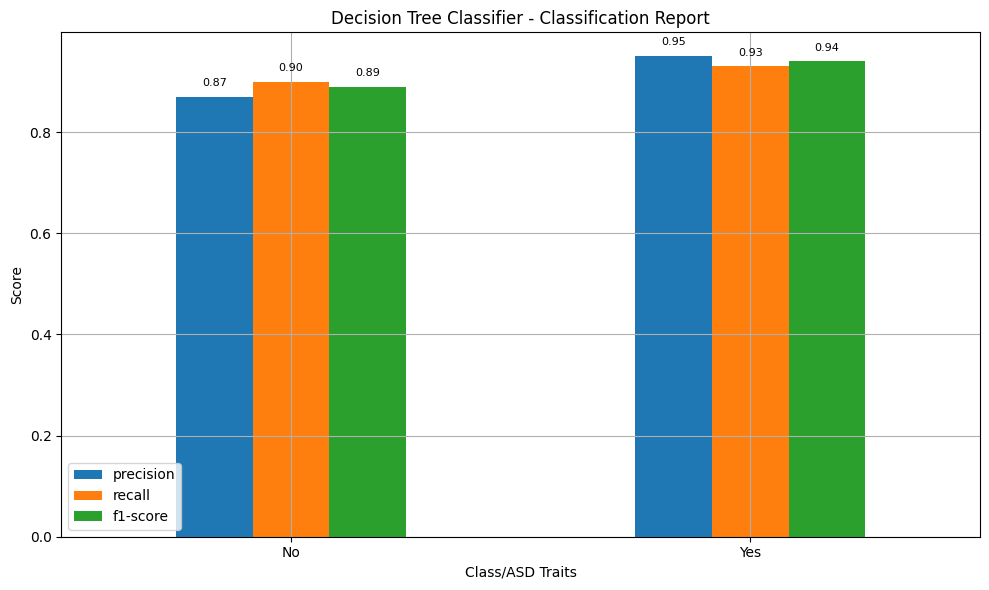

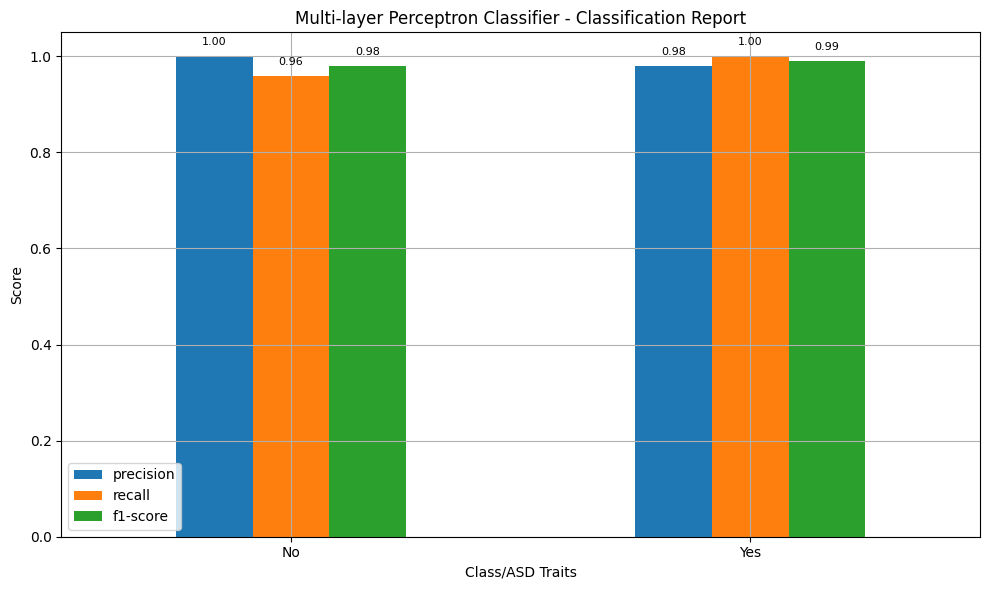

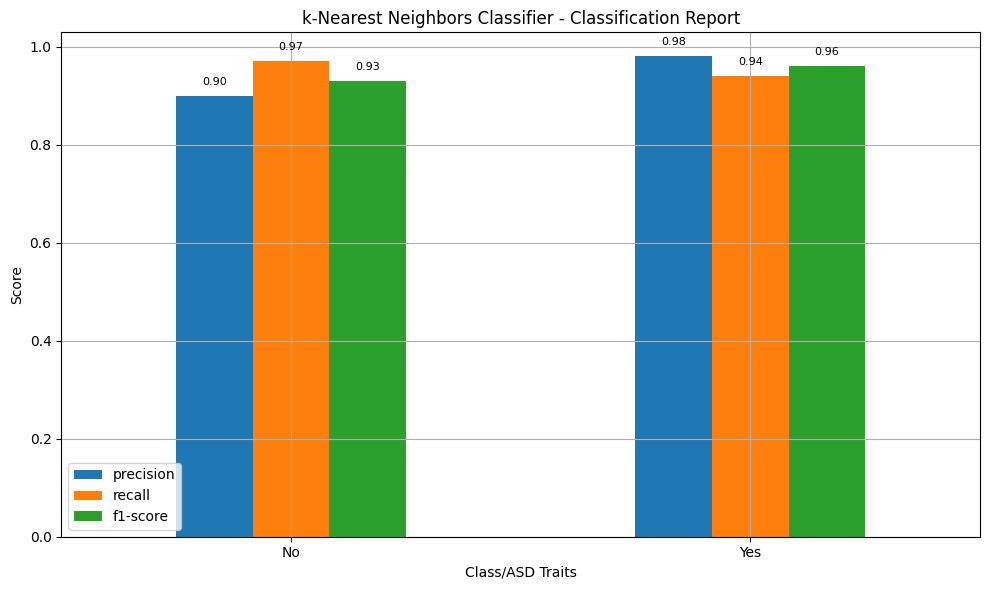

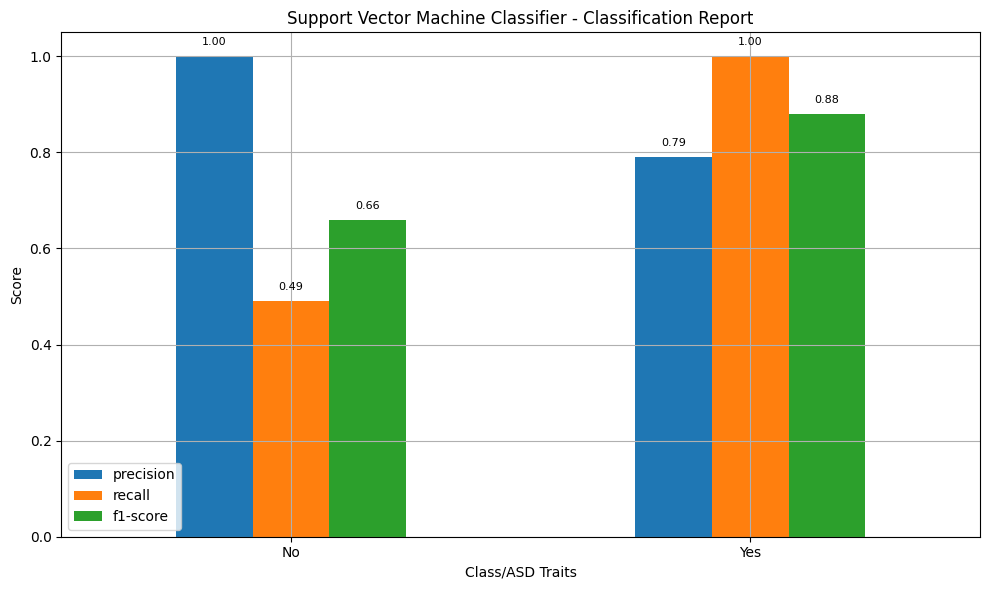

In [210]:
# Plot classification report for each classifier
for name, classifier in classifiers.items():
    y_pred = classifier.predict(X_test)
    report = classification_report(y_test, y_pred)
    title = f'{name} Classifier - Classification Report'
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-5]:
        row = {}
        row_data = line.split()
        row['class'] = 'Yes' if row_data[0] == '1' else 'No'
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1-score'] = float(row_data[3])
        report_data.append(row)
    df = pd.DataFrame(report_data)
    df.set_index('class', inplace=True)
    ax = df.plot(kind='bar', figsize=(10, 6))

    # Add value annotations on top of each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=8)

    plt.title(title)
    plt.xlabel('Class/ASD Traits')
    plt.ylabel('Score')
    plt.xticks(rotation=0)
    plt.grid(True)
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.show()


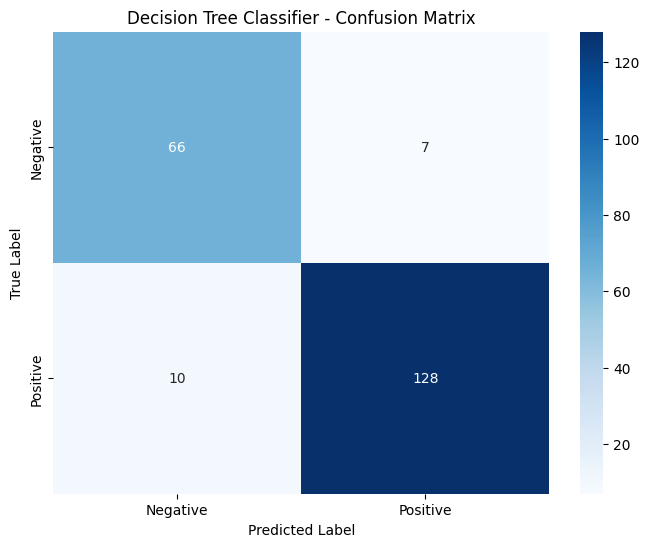

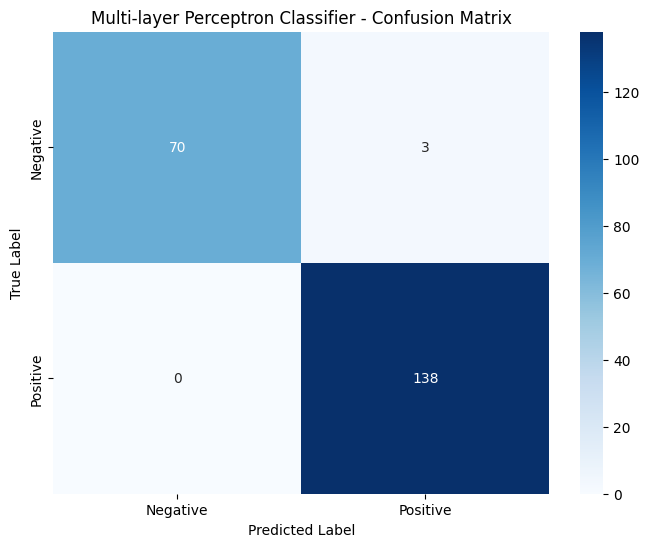

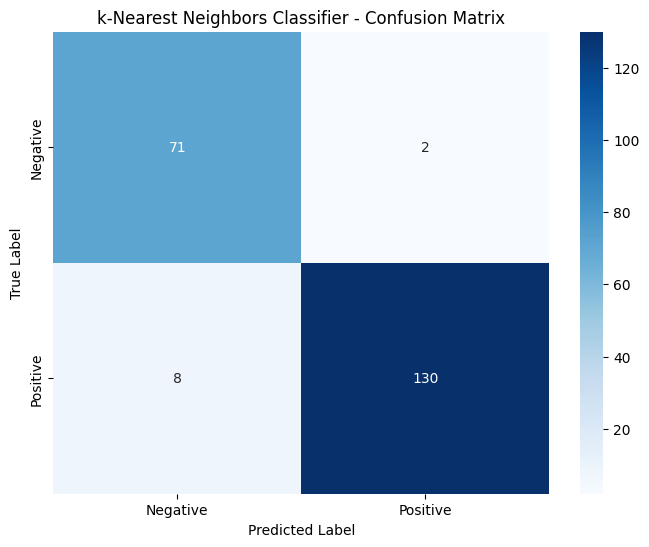

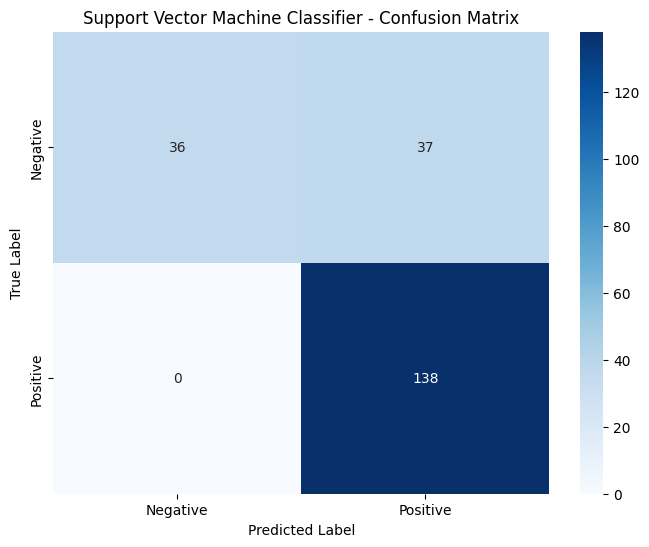

In [211]:
# Plot confusion matrix for each classifier
for name, classifier in classifiers.items():
    y_pred = classifier.predict(X_test)
    confusion = confusion_matrix(y_test, y_pred)
    title = f'{name} Classifier - Confusion Matrix'
    plt.figure(figsize=(8, 6))
    labels = ['Negative', 'Positive']
    sb.heatmap(confusion, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()